## Libraries

In [453]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

## Preliminary EDA

We first did quick EDA on the variables in the dataset to get familiar with them and to identify any that might need extra cleaning.

In [539]:
df = pd.read_csv('KaggleV2-May-2016.csv')

In [540]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [541]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [542]:
#convert dates to datetime format

from datetime import datetime

df.ScheduledDay = pd.to_datetime(df.ScheduledDay)
df.AppointmentDay = pd.to_datetime(df.AppointmentDay)

In [543]:
AwaitingTime = df.ScheduledDay - df.AppointmentDay
AwaitingTime = AwaitingTime.apply(lambda x: x.days)
AwaitingTime = AwaitingTime.apply(abs)

In [544]:
#check if the conversion went right
df['Gender'].unique()

array(['F', 'M'], dtype=object)

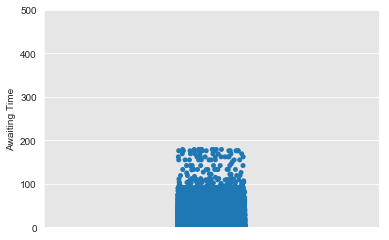

In [545]:
# Checking for outliers in AwaitingTime
sns.stripplot(data = df, y = AwaitingTime, jitter = True)
plt.ylabel('Awaiting Time')
plt.ylim(0, 500)
plt.show()

## Exploring The Data

Now we are all set to explore the different features of the data and determine how good a feature it is for prediction whether a patient is likely to show up at an appointment.

### Analyzing the probability of showing up with respect to different features

In [546]:
df.ScheduledDay = df.ScheduledDay.apply(np.datetime64)
df['NoShow'] = df['No-show']
def calculateHour(timestamp):
    timestamp = str(timestamp)
    hour = int(timestamp[11:13])
    minute = int(timestamp[14:16])
    second = int(timestamp[17:])
    return round(hour + minute/60 + second/3600)

df['HourOfTheDay'] = df.ScheduledDay.apply(calculateHour)

In [547]:
def probStatus(dataset, group_by):
    df = pd.crosstab(index = dataset[group_by], columns = dataset.NoShow).reset_index()
    df['probShowUp'] = df['No'] / (df['No'] + df['Yes'])
    return df[[group_by, 'probShowUp']]

First we will check how the likelihood that a person will show up at an appointment changes with respect to Age, HourOfTheDay.

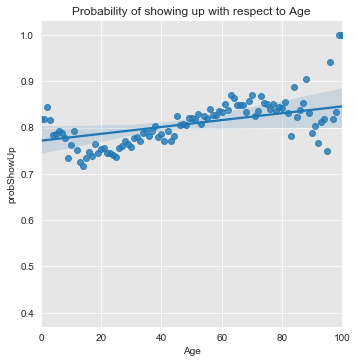

In [548]:
sns.lmplot(data = probStatus(df, 'Age'), x = 'Age', y = 'probShowUp', fit_reg = True)
plt.xlim(0, 100)
plt.title('Probability of showing up with respect to Age')
plt.show()

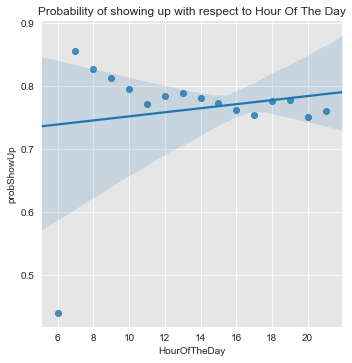

In [549]:
sns.lmplot(data = probStatus(df, 'HourOfTheDay'), x = 'HourOfTheDay', 
           y = 'probShowUp', fit_reg = True)
plt.title('Probability of showing up with respect to Hour Of The Day')
plt.show()


In [550]:
df['No-show'] = df['No-show'].replace('Yes', 1) 
df['No-show'] = df['No-show'].replace('No', 0)

In [551]:
df.AppointmentDay = df.AppointmentDay.apply(np.datetime64)

def calculateday(datetime):
    #year, month, day = (int(x) for x in date.split('-'))    
    DayOfTheWeek = datetime.date().strftime("%A")
    return DayOfTheWeek

df['DayOfTheWeek'] = df['AppointmentDay'].apply(lambda x: calculateday(x))

Clearly, HourOfTheDay and other features are not good predictors of Status, since the probability of showing up depends feebly on the HourOfTheDay and not at all on the AwaitingTime. The significantly stronger dependency is observed with respect to Age.

Next, we do the same analysis for the other variables except AppointmentRegistration and AppointmentData since we have already analyzed the probability of showing up with respect to HourOfTheDay and AwaitingTime.

In [552]:
def probStatusCategorical(group_by):
    rows = []
    for item in group_by:
        for level in df[item].unique():
            row = {'Condition': item}
            total = len(df[df[item] == level])
            n = len(df[(df[item] == level) & (df.NoShow == 'No')])
            row.update({'Level': level, 'Probability': n / total})
            rows.append(row)
    return pd.DataFrame(rows)

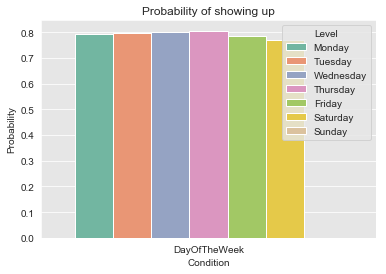

In [553]:
sns.barplot(data = probStatusCategorical(['DayOfTheWeek']),
            x = 'Condition', y = 'Probability', hue = 'Level', palette = 'Set2',
           hue_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                       'Saturday', 'Sunday'])
plt.title('Probability of showing up')
plt.ylabel('Probability')
plt.show()

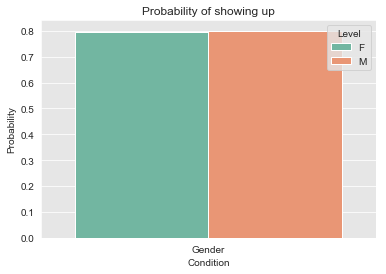

In [554]:
sns.barplot(data = probStatusCategorical(['Gender']),
            x = 'Condition', y = 'Probability', hue = 'Level', palette = 'Set2')
plt.title('Probability of showing up')
plt.ylabel('Probability')
plt.show()

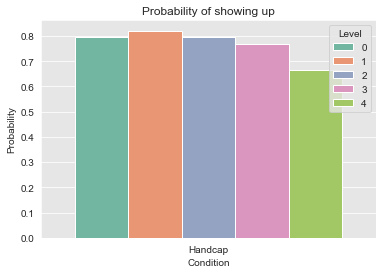

In [555]:
sns.barplot(data = probStatusCategorical(['Handcap']),
            x = 'Condition', y = 'Probability', hue = 'Level', palette = 'Set2')
plt.title('Probability of showing up')
plt.ylabel('Probability')
plt.show()

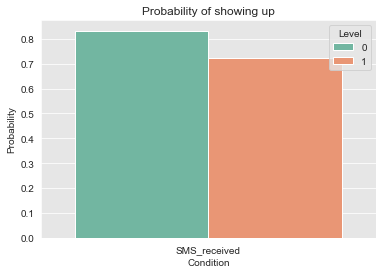

In [556]:
sns.barplot(data = probStatusCategorical(['SMS_received']),
            x = 'Condition', y = 'Probability', hue = 'Level', palette = 'Set2')
plt.title('Probability of showing up')
plt.ylabel('Probability')
plt.show()

In [557]:
#convert gender to numerical values
df['Gender'] = df['Gender'].replace('F', 0)
df['Gender'] = df['Gender'].replace('M', 1)

### Multicollinearity Analysis

In [473]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 8 columns):
Gender          110527 non-null int64
Age             110527 non-null int64
Scholarship     110527 non-null int64
Hipertension    110527 non-null int64
Diabetes        110527 non-null int64
Alcoholism      110527 non-null int64
Handcap         110527 non-null int64
SMS_received    110527 non-null int64
dtypes: int64(8)
memory usage: 6.7 MB


In [474]:
X.corr()

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
Gender,1.000000,-0.106440,-0.114293,-0.055718,-0.032554,0.106167,0.022814,-0.046298
Age,-0.106440,1.000000,-0.092457,0.504586,0.292391,0.095811,0.078033,0.012643
Scholarship,-0.114293,-0.092457,1.000000,-0.019729,-0.024894,0.035022,-0.008586,0.001194
Hipertension,-0.055718,0.504586,-0.019729,1.000000,0.433086,0.087971,0.080083,-0.006267
Diabetes,-0.032554,0.292391,-0.024894,0.433086,1.000000,0.018474,0.057530,-0.014550
Alcoholism,0.106167,0.095811,0.035022,0.087971,0.018474,1.000000,0.004648,-0.026147
Handcap,0.022814,0.078033,-0.008586,0.080083,0.057530,0.004648,1.000000,-0.024161
SMS_received,-0.046298,0.012643,0.001194,-0.006267,-0.014550,-0.026147,-0.024161,1.000000


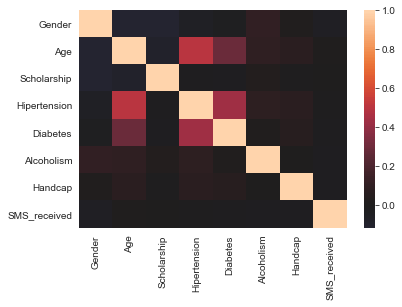

In [475]:
sns.heatmap(X.corr(), center=0);

# Train/Test Split

Before running any modeling, we want to separate our data into train and test sets. We will train our models on train and do final validation on test.

In [476]:
# Set seed for reproducibility
np.random.seed(1111)

In [477]:
#Our first model
X = df[['Gender', 'Age', 'Scholarship', 
        'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received']]

y = df['No-show']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

## Model 1 - All Candidate Variables

We are going to start modeling to learn more above our variables! For this first run we are going to use ALL our non-categorical variables.

# Random Forest Classifier

In [478]:
# Random Forest Classifier
rfc = ensemble.RandomForestClassifier(n_estimators=100)
rfc.fit(X_train,y_train)
print(rfc)
print('Training set score:', rfc.score(X_train,y_train))


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Training set score: 0.8016082152429853


In [479]:
print("Report:")
y_true, y_pred = y_test, rfc.predict(X_test)
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

Report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     17725
           1       0.32      0.02      0.03      4381

    accuracy                           0.80     22106
   macro avg       0.56      0.50      0.46     22106
weighted avg       0.71      0.80      0.72     22106



array([[17566,   159],
       [ 4305,    76]])

In [480]:
RFC_score = cross_val_score(rfc, X_test,y_test, cv=5)
print('\nEach Cross Validated Accuracy: \n', RFC_score)
print("\nOverall Random Forest Classifier Accuracy: %0.2f (+/- %0.2f)\n" % (RFC_score.mean(), RFC_score.std() * 2))


Each Cross Validated Accuracy: 
 [0.79081863 0.79416422 0.79416422 0.79077132 0.78918797]

Overall Random Forest Classifier Accuracy: 0.79 (+/- 0.00)



We'll begin by fitting a regular Decision Tree Classifier, so that we have something to compare our ensemble methods to.

### Building the tree

In the cell below, create a Decision Tree Classifier. Set the criterion to 'gini', and a max_depth of 5. Then, fit the tree to our training data and labels.

In [481]:
tree_clf = DecisionTreeClassifier(criterion = "gini", max_depth = 5) 
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### Feature importance

Let's quickly examine how important each feature ended up being in our Decision Tree model. Check the feature_importances_ attribute of our trained model to see what it displays.

In [482]:
tree_clf.feature_importances_

array([0.00733887, 0.37834952, 0.01772966, 0.00597924, 0.        ,
       0.00473978, 0.00287941, 0.58298352])

### Model performance

Next, let's see how well our model performed on the data.

In the cell below:

1. Use the classifier to create predictions on our test set.
2. Print out a confusion_matrix of our test set predictions.
3. Print out a classification_report of our test set predictions.

In [483]:
pred = tree_clf.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[17721     4]
 [ 4380     1]]
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     17725
           1       0.20      0.00      0.00      4381

    accuracy                           0.80     22106
   macro avg       0.50      0.50      0.45     22106
weighted avg       0.68      0.80      0.71     22106



# Logistic Regression

### Fit a model

In [484]:
logreg = LogisticRegression(fit_intercept = False, C = 1e12, solver = 'lbfgs')
model_log = logreg.fit(X_train, y_train)
print(model_log)
print('Training set score:', logreg.score(X_train,y_train))

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Training set score: 0.7904909467208017


### Predict

In [485]:
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

#### How many times was the classifier correct for the training set?

In [486]:
#Initial Evaluation

residuals = y_train - y_hat_train
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

 0    69896
 1    17503
-1     1022
Name: No-show, dtype: int64
 0    0.790491
 1    0.197951
-1    0.011558
Name: No-show, dtype: float64


#### How many times was the classifier correct for the test set?

In [487]:
residuals = y_test - y_hat_test
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

 0    17571
 1     4288
-1      247
Name: No-show, dtype: int64
 0    0.794852
 1    0.193974
-1    0.011173
Name: No-show, dtype: float64


In [488]:
print("Report:")
y_true, y_pred = y_test, logreg.predict(X_test)
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

Report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     17725
           1       0.27      0.02      0.04      4381

    accuracy                           0.79     22106
   macro avg       0.54      0.50      0.46     22106
weighted avg       0.70      0.79      0.72     22106



array([[17478,   247],
       [ 4288,    93]])

In [489]:
LR_score = cross_val_score(logreg, X_test, y_test, cv=5)
print('\nEach Cross Validated Accuracy score: \n', LR_score)
print("\nOverall Logistic Regression Accuracy: %0.2f (+/- %0.2f)\n" % (LR_score.mean(), LR_score.std() * 2))


Each Cross Validated Accuracy score: 
 [0.79715061 0.79280706 0.79280706 0.79574757 0.79619995]

Overall Logistic Regression Accuracy: 0.79 (+/- 0.00)



# Support Vector Classifier

In [420]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')
svc_model = svc.fit(X_train,y_train)
print(svc_model)
print('Training set score:', svc_model.score(X_train,y_train))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Training set score: 0.797129641148596


In [422]:
SVC_score = cross_val_score(svc, X_test, y_test, cv=5)
print('\nEach Cross Validated Accuracy score: \n', SVC_score)
print("\nOverall Logistic Regression/Support Vector Classifier Accuracy: %0.2f (+/- %0.2f)\n" % (SVC_score.mean(), SVC_score.std() * 2))



Each Cross Validated Accuracy score: 
 [0.80167345 0.80185478 0.80185478 0.80185478 0.80185478]

Overall Logistic Regression/Support Vector Classifier Accuracy: 0.80 (+/- 0.00)



## Class Imbalance

### Create an initial model

AUC: 0.5515838009303541


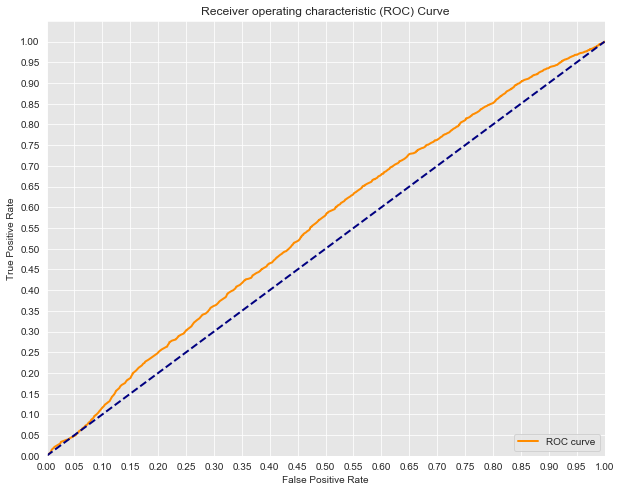

In [490]:
#Initial Model
logreg = LogisticRegression(fit_intercept = False, solver= 'lbfgs')

#Probability scores for test set
y_score = logreg.fit(X_train, y_train).decision_function(X_test)
#False positive Rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_score)

#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Comparing Models with Varying Class Weights

As a baseline, fit a cookie cutter out of the box logistic regression model. Then plot the ROC curve and print out the AUC. We'll use this as a comparison for how our future models perform.

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for None: 0.5515783150023712
LogisticRegression(C=1000000000000.0, class_weight='balanced', dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for Balanced: 0.5925400393866449
LogisticRegression(C=1000000000000.0, class_weight={0: 1, 1: 2}, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
             

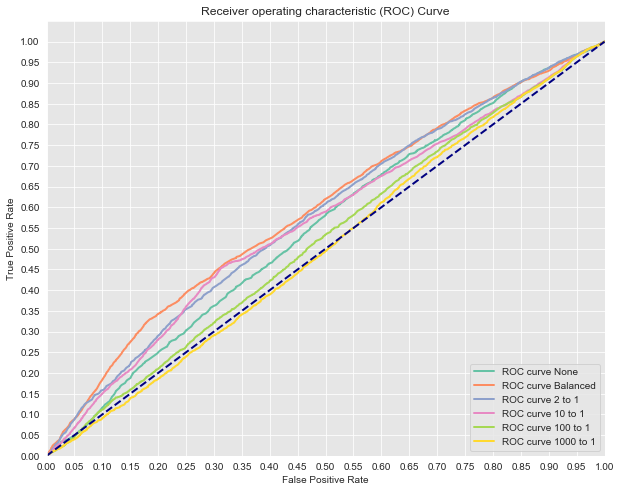

In [491]:
# Now let's compare a few different regularization performances on the dataset:
weights = [None, 'balanced', {1:2, 0:1}, {1:10, 0:1}, {1:100, 0:1}, {1:1000, 0:1}]
names = ['None', 'Balanced', '2 to 1', '10 to 1', '100 to 1', '1000 to 1']
colors = sns.color_palette("Set2")

plt.figure(figsize=(10,8))

for n, weight in enumerate(weights):
    #Fit a model
    logreg = LogisticRegression(fit_intercept = False, C = 1e12, class_weight=weight, solver = 'lbfgs')
    model_log = logreg.fit(X_train, y_train)
    print(model_log) #Preview model params

    #Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

As you can see, class weight can have an impact! In this case, typically the heavier that we weight the positive case, the better our classifier appears to be performing.

In [492]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[  191    37]
 [17534  4344]]


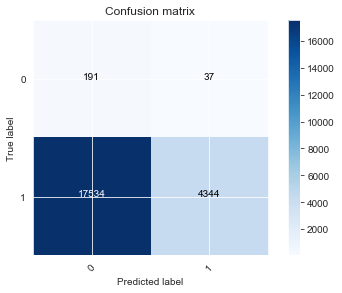

In [493]:
y_hat_test = logreg.predict(X_test)
cnf_matrix = confusion_matrix(y_hat_test, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0,1])

## Tunning

Try some of the various techniques proposed to tune your model. Compare your models using AUC, ROC or another metric.

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.001: 0.5506351861110726
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.01: 0.551959548363896
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001

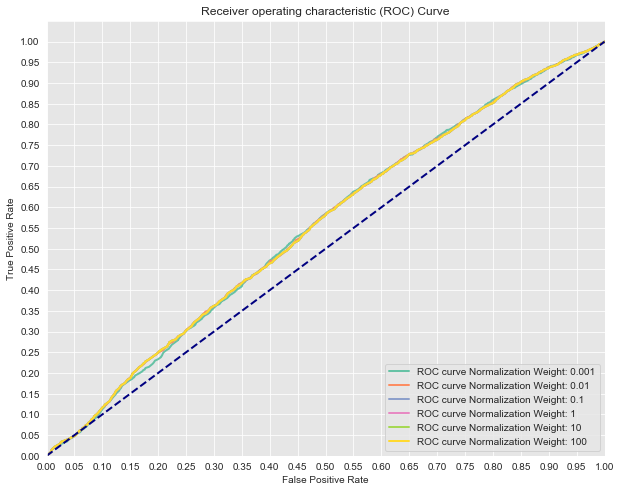

In [494]:
# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.001,0.01,0.1,1,10,100]
names = [0.001,0.01,0.1,1,10,100]
colors = sns.color_palette("Set2")

plt.figure(figsize=(10,8))

for n, c in enumerate(C_param_range):
    #Fit a model
    logreg = LogisticRegression(fit_intercept = False, C = c, solver= 'lbfgs')
    model_log = logreg.fit(X_train, y_train)
    print(model_log) #Preview model params

    #Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Confusion matrix, without normalization
[[17478  4288]
 [  247    93]]


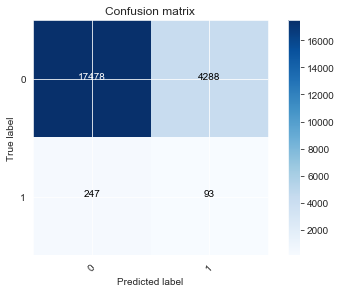

In [495]:
cnf_matrix = confusion_matrix(y_hat_test, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0,1])

## Model 2 - Performed Data Cleaning and One Hot Encoding on the features

In [496]:
df_new_model = df.copy() # dataframe copy

In [497]:
df_new_model['days_in_advance'] =  df_new_model.AppointmentDay - df_new_model.ScheduledDay
df_new_model['days_in_advance'] = df_new_model['days_in_advance'].apply(lambda x: x.days)

In [498]:
df_new_model = df_new_model.drop(df_new_model[df_new_model['days_in_advance'] < 0].index)

In [499]:
df_new_model = df_new_model.reset_index(drop=True)

In [500]:
df_new_model['appointment_month'] =  df_new_model.AppointmentDay.apply(lambda x: x.month)

In [501]:
df_new_model['appointment_day_of_the_week'] =  df_new_model.AppointmentDay.apply(lambda x: x.weekday())

In [502]:
from sklearn.preprocessing import OneHotEncoder

In [503]:
month_category = df_new_model["appointment_month"].values.reshape(-1, 1)

In [504]:
encoder = OneHotEncoder(drop='first', categories='auto').fit(month_category)

In [505]:
encoder.get_feature_names(["month_appointment"])

array(['month_appointment_5', 'month_appointment_6'], dtype=object)

In [506]:
ohe = pd.DataFrame(encoder.transform(month_category).toarray(),
                   columns=encoder.get_feature_names(["month_appointment"]))

In [507]:
df_new_model = df_new_model.drop(["appointment_month"], axis=1)

In [508]:
df_new_model = pd.concat([df_new_model, ohe], axis=1, join='inner')

In [509]:
day_of_week_category = df_new_model["appointment_day_of_the_week"].values.reshape(-1, 1)

In [510]:
encoder = OneHotEncoder(drop='first', categories='auto').fit(day_of_week_category)

In [511]:
encoder.get_feature_names(["day_of_week_appointment"])

array(['day_of_week_appointment_1', 'day_of_week_appointment_2',
       'day_of_week_appointment_3', 'day_of_week_appointment_4',
       'day_of_week_appointment_5'], dtype=object)

In [512]:
ohe = pd.DataFrame(encoder.transform(day_of_week_category).toarray(),
                   columns=encoder.get_feature_names(["day_of_week_appointment"]))

In [513]:
df_new_model = pd.concat([df_new_model.drop("appointment_day_of_the_week", axis=1), ohe], axis=1, join='inner')

In [514]:
df_new_model.tail()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,...,HourOfTheDay,DayOfTheWeek,days_in_advance,month_appointment_5,month_appointment_6,day_of_week_appointment_1,day_of_week_appointment_2,day_of_week_appointment_3,day_of_week_appointment_4,day_of_week_appointment_5
71954,2.572134e+12,5651768,0,2016-05-03 09:15:35,2016-06-07,56,MARIA ORTIZ,0,0,0,...,9,Tuesday,34,0.0,1.0,1.0,0.0,0.0,0.0,0.0
71955,3.596266e+12,5650093,0,2016-05-03 07:27:33,2016-06-07,51,MARIA ORTIZ,0,0,0,...,7,Tuesday,34,0.0,1.0,1.0,0.0,0.0,0.0,0.0
71956,1.557663e+13,5630692,0,2016-04-27 16:03:52,2016-06-07,21,MARIA ORTIZ,0,0,0,...,16,Tuesday,40,0.0,1.0,1.0,0.0,0.0,0.0,0.0
71957,9.213493e+13,5630323,0,2016-04-27 15:09:23,2016-06-07,38,MARIA ORTIZ,0,0,0,...,15,Tuesday,40,0.0,1.0,1.0,0.0,0.0,0.0,0.0
71958,3.775115e+14,5629448,0,2016-04-27 13:30:56,2016-06-07,54,MARIA ORTIZ,0,0,0,...,14,Tuesday,40,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [515]:
# Set seed for reproducibility
np.random.seed(1111)

In [516]:
y = df_new_model['No-show']
X = df_new_model[['Gender', 'Age', 'Scholarship', 
       'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received',
       'days_in_advance','month_appointment_5','month_appointment_6','day_of_week_appointment_1',
        'day_of_week_appointment_2','day_of_week_appointment_3','day_of_week_appointment_4',
        'day_of_week_appointment_5']]

# X = df_new_model[['Age','days_in_advance','Gender','SMS_received','day_of_week_appointment_1',
#                  'Handcap','Hipertension']]

X_train_new_model, X_test_new_model, y_train_new_model, y_test_new_model = train_test_split(X, y, test_size = 0.2, random_state=0)

In [523]:
from sklearn.ensemble import ExtraTreesClassifier

[1.38901868e-02 5.19317048e-01 5.59876392e-03 6.79580928e-03
 6.61250850e-03 4.01643483e-03 7.56075608e-03 8.90617608e-03
 3.97392435e-01 2.65510618e-03 2.46051480e-03 7.78252893e-03
 5.41668876e-03 5.06138245e-03 6.25197648e-03 2.81683719e-04]


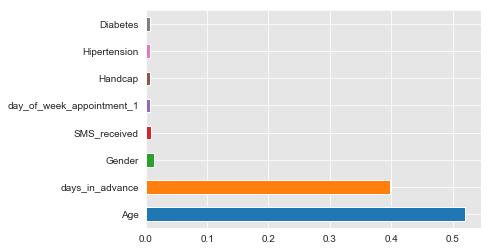

In [524]:
import matplotlib.pyplot as plt
model = ExtraTreesClassifier(n_estimators=100)
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(8).plot(kind='barh')
plt.show()

## Logistic Regression

In [525]:
# Fit a model
logreg = LogisticRegression(fit_intercept = False, max_iter = 4000, solver = 'lbfgs', C = 1e12)
model_log = logreg.fit(X_train_new_model, y_train_new_model)
print(model_log)
print('Training set score:', logreg.score(X_train_new_model,y_train_new_model))

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=4000, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Training set score: 0.7151666753521984


In [526]:
print("Report:")
y_true, y_pred = y_test_new_model, logreg.predict(X_test_new_model)
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83     10258
           1       0.48      0.00      0.01      4134

    accuracy                           0.71     14392
   macro avg       0.60      0.50      0.42     14392
weighted avg       0.65      0.71      0.59     14392



array([[10244,    14],
       [ 4121,    13]])

In [527]:
LR_score = cross_val_score(logreg, X_test_new_model, y_test_new_model, cv=5)
print('\nEach Cross Validated Accuracy score: \n', LR_score)
print("\nOverall Logistic Regression Accuracy: %0.2f (+/- %0.2f)\n" % (LR_score.mean(), LR_score.std() * 2))


Each Cross Validated Accuracy score: 
 [0.71170545 0.71274748 0.71344217 0.71264767 0.71289538]

Overall Logistic Regression Accuracy: 0.71 (+/- 0.00)



## Class Imbalance

### Create an initial model

AUC: 0.5900976975927221


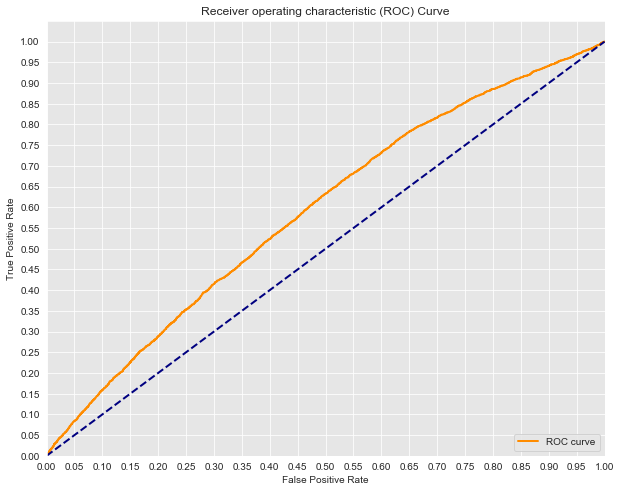

In [528]:
#Initial Model
logreg = LogisticRegression(fit_intercept = False, solver= 'lbfgs', max_iter=1000)

#Probability scores for test set
y_score = logreg.fit(X_train_new_model, y_train_new_model).decision_function(X_test_new_model)
#False positive Rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test_new_model, y_score)

#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Comparing Models with Varying Class Weights

As a baseline, fit a cookie cutter out of the box logistic regression model. Then plot the ROC curve and print out the AUC. We'll use this as a comparison for how our future models perform.

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for None: 0.5900886188112542
LogisticRegression(C=1000000000000.0, class_weight='balanced', dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for Balanced: 0.5913675715169809
LogisticRegression(C=1000000000000.0, class_weight={0: 1, 1: 2}, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='warn', n_jobs=None, penalty='l2',
          

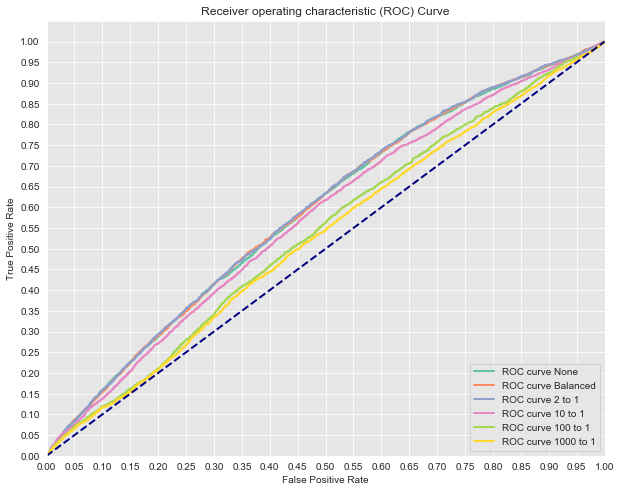

In [529]:
# Now let's compare a few different regularization performances on the dataset:
weights = [None, 'balanced', {1:2, 0:1}, {1:10, 0:1}, {1:100, 0:1}, {1:1000, 0:1}]
names = ['None', 'Balanced', '2 to 1', '10 to 1', '100 to 1', '1000 to 1']
colors = sns.color_palette("Set2")

plt.figure(figsize=(10,8))

for n, weight in enumerate(weights):
    #Fit a model
    logreg = LogisticRegression(fit_intercept = False, C = 1e12, class_weight=weight, solver = 'lbfgs', max_iter=1000)
    model_log = logreg.fit(X_train_new_model, y_train_new_model)
    print(model_log) #Preview model params

    #Predict
    y_hat_test = logreg.predict(X_test_new_model)

    y_score = logreg.fit(X_train_new_model, y_train_new_model).decision_function(X_test_new_model)

    fpr, tpr, thresholds = roc_curve(y_test_new_model, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Confusion matrix, without normalization
[[    0     0]
 [10258  4134]]


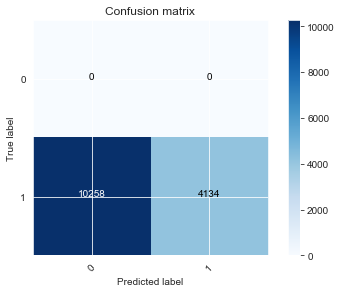

In [530]:
y_hat_test = logreg.predict(X_test_new_model)
cnf_matrix = confusion_matrix(y_hat_test, y_test_new_model)
plot_confusion_matrix(cnf_matrix, classes=[0,1])

## Tunning

Try some of the various techniques proposed to tune your model. Compare your models using AUC, ROC or another metric.

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.001: 0.5885737828561102
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for 0.01: 0.5908422284168595
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.

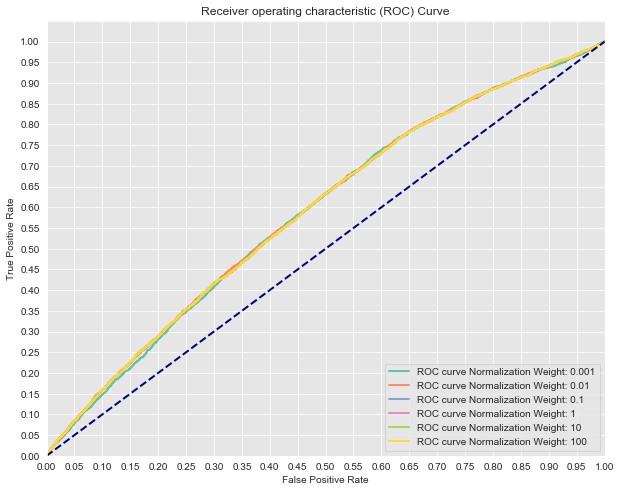

In [531]:
# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.001,0.01,0.1,1,10,100]
names = [0.001,0.01,0.1,1,10,100]
colors = sns.color_palette("Set2")

plt.figure(figsize=(10,8))

for n, c in enumerate(C_param_range):
    #Fit a model
    logreg = LogisticRegression(fit_intercept = False, C = c, solver= 'lbfgs', max_iter=1000)
    model_log = logreg.fit(X_train_new_model, y_train_new_model)
    print(model_log) #Preview model params

    #Predict
    y_hat_test = logreg.predict(X_test_new_model)

    y_score = logreg.fit(X_train_new_model, y_train_new_model).decision_function(X_test_new_model)

    fpr, tpr, thresholds = roc_curve(y_test_new_model, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Confusion matrix, without normalization
[[10245  4121]
 [   13    13]]


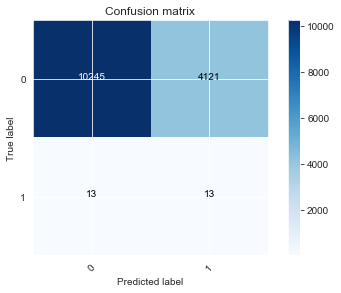

In [532]:
cnf_matrix = confusion_matrix(y_hat_test, y_test_new_model)
plot_confusion_matrix(cnf_matrix, classes=[0,1])

## Random Forest Classifier

In [533]:
rfc = ensemble.RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_new_model,y_train_new_model)
print(rfc)
print('Training set score:', rfc.score(X_train_new_model,y_train_new_model))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Training set score: 0.9073253773863498


In [534]:
print("Report:")
y_true, y_pred = y_test_new_model, rfc.predict(X_test_new_model)
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

Report:
              precision    recall  f1-score   support

           0       0.73      0.82      0.77     10258
           1       0.35      0.24      0.29      4134

    accuracy                           0.65     14392
   macro avg       0.54      0.53      0.53     14392
weighted avg       0.62      0.65      0.63     14392



array([[8393, 1865],
       [3134, 1000]])

In [535]:
RFC_score = cross_val_score(rfc, X_test_new_model,y_test_new_model, cv=5)
print('\nEach Cross Validated Accuracy: \n', RFC_score)
print("\nOverall Random Forest Classifier Accuracy: %0.2f (+/- %0.2f)\n" % (RFC_score.mean(), RFC_score.std() * 2))


Each Cross Validated Accuracy: 
 [0.64084752 0.65995137 0.64432094 0.66018068 0.64789712]

Overall Random Forest Classifier Accuracy: 0.65 (+/- 0.02)



## Support Vector Classifier

In [339]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')
svc_model = svc.fit(X_train_new_model,y_train_new_model)
print(svc_model)
print('Training set score:', svc_model.score(X_train_new_model,y_train_new_model))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Training set score: 0.7153230149217433


In [340]:
SVC_score = cross_val_score(svc, X_test_new_model, y_test_new_model, cv=5)
print('\nEach Cross Validated Accuracy score: \n', SVC_score)
print("\nOverall Logistic Regression/Support Vector Classifier Accuracy: %0.2f (+/- %0.2f)\n" % (SVC_score.mean(), SVC_score.std() * 2))



Each Cross Validated Accuracy score: 
 [0.71274748 0.71274748 0.71274748 0.71264767 0.71289538]

Overall Logistic Regression/Support Vector Classifier Accuracy: 0.71 (+/- 0.00)

